## Import libraries and code

In [5]:
import load_data_multitox as ld
import dataloaders_sigma as dl
from Model_train_test_regression import Net, EarlyStopping, train_regression, test_regression, train_classification, test_classification

import pandas as pd
import numpy as np

import torch
from torch.utils import data as td
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter

import sys 
import os
import glob

from sklearn.model_selection import train_test_split

from tensorboardX import SummaryWriter

import time
from sklearn.preprocessing import MinMaxScaler#StandardScaler

import json


# number of conformers created for every molecule
NUM_CONFS = 100

# amount of chemical elements taking into account
AMOUNT_OF_ELEM = 9

# amount of target values
TARGET_NUM = 29

#dataset folder
# DATASET_PATH="~/Tox21-MultiTox/MultiTox"
DATASET_PATH="/gpfs/gpfs0/a.alenicheva/Tox21/elements_9"

## Creating dataframe with molecules and properties
example of code, needed datset already in `tox21_10k_data_all_no_salts.csv`

In [6]:
# #load dataset to dataframe
# data=cs.create_dataset()

# #delete repeating molecules values
# data=cs.del_duplicates(data)

# #delete molecules, that are not in sql database due to errors in rdkit
# data=cs.del_wrong_smiles(data)

## Loading data into dictionary

In [7]:
# #get dataset without duplicates from csv
# data=pd.read_csv('tox21_10k_data_all_no_salts.csv')

# #create elements dictionary
# elements=ld.create_element_dict(data,amount=AMOUNT_OF_ELEM)

# #read databases to dictionary
# conf_calc=ld.reading_sql_database()

# #create indexing and label_dict for iteration
# indexing,label_dict=ld.indexing_label_dict(data,conf_calc)

In [8]:
# len(list(conf_calc.keys()))

In [9]:
#get dataset without duplicates from csv
data = pd.read_csv(os.path.join('../Tox21_Neural_Net/database', 'tox21_10k_data_all_no_salts.csv'))

#create elements dictionary
# elements=ld.create_element_dict(data,amount=AMOUNT_OF_ELEM)
elements = {'I': 0,
 'P': 1,
 'Br': 2,
 'F': 3,
 'S': 4,
 'Cl': 5,
 'N': 6,
 'O': 7,
 'C': 8}

#read databases to dictionary
conf_calc = ld.reading_sql_database(DATASET_PATH)

#create indexing and label_dict for iteration
indexing,label_dict=ld.indexing_label_dict(data,conf_calc)

In [10]:
len(list(conf_calc.keys()))

7489

In [11]:
EXPERIMENT_NUM=52

In [12]:
path="./"
with open(os.path.join(path,"logs_sigma_right",'exp_'+str(24),str(24)+'_parameters.json'),'r') as f:
  args = json.load(f)

In [13]:
args

{'EPOCHS_NUM': 100,
 'PATIENCE': 25,
 'SIGMA': 1.4,
 'BATCH_SIZE': 128,
 'TRANSF': 'g',
 'NUM_EXP': '24',
 'VOXEL_DIM': 50,
 'LEARN_RATE': 1e-05,
 'SIGMA_TRAIN': False}

In [23]:
args['SIGMA'] = 7
args['TRANSF'] = 'w'

In [36]:
class Net(nn.Module):
    """
    The Net class constructs neural network with ActivNet4 architecture.

    Attributes
    ----------
    dim : int
        Dimension of 3D cube where each type of atoms are stored
    num_elems : int
        Number of types of atoms represented molecule (number of cubes storing information about molecule's structure) 
    num_targets : int
        Number of predicted labels
    transform : str
        Type of transformation applied to atom grid:
        'g' - Gauss transformation
        'w' - Waves transformation
    dx : float
        Size of grid cell in angstrom
    elements: dict
        Dictionary with {atom name : number} mapping
    device : str
        Torch device
    sigma : torch.Tensor
        Tensor containing sigmas for each type of atom
        
    convolution : nn.Sequential
        Set of convolutions, pooling and non-linearities 
    fc1 : nn.Linear
        First dense layer
    fc2 : nn.Linear
        Second dense layer
        
    blur : function
        Apply transformation to batch of molecules
    forward : function
        Apply neural network to batch of molecules
    """
    def __init__(self, dim=70, kernel_size=51,
                 num_elems=9, 
                 num_targets=29, 
                 transformation='g', 
                 dx=0.5,
                 elements=None,
                 device='cpu',
                 sigma_trainable = False,
                 sigma_0=3, 
                 x_trainable = False,
                 mode = 'r',
                 x_input=None):
        """
        Initialize neural network.

        Parameters
        ----------
        dim : int
            Dimension of 3D cube where each type of atoms are stored
        kernel_size : int
            Size of convolution kernel for gauss or wave transformation
        num_elems : int
            Number of types of atoms represented molecule (number of cubes storing information about molecule's structure) 
        num_targets : int
            Number of predicted labels
        transformation : str
            Type of transformation applied to atom grid:
            'g' - Gauss transformation
            'w' - Waves transformation
        dx : float
            Size of grid cell in angstrom
        elements: dict
            Dictionary with {atom name : number} mapping
        device : str
            Torch device
        sigma_trainable : boolean
            Should sigma be trainable parameter or not
        sigma_0 : float or numpy array (len(elements),)
            Initial value of sigma parameter (in grid cells)
        """
        super(Net, self).__init__()
        
        if sigma_trainable:
            self.sigma = Parameter(sigma_0*torch.ones(num_elems).float().to(device),requires_grad=True)
            self.register_parameter('sigma',self.sigma)
        else:
            self.register_buffer('sigma', sigma_0*torch.ones(num_elems).float().to(device))
            
        if x_trainable:
            self.x_input = Parameter(x_input.to(device),requires_grad=True)
            self.register_parameter('x_input',self.x_input)
        else:
            self.register_buffer('x_input',torch.zeros(1, num_elems, dim, dim, dim).float().to(device))
        

        

        # initialize dimensions
        self.dim = dim
        self.kernel_size=kernel_size
        self.num_elems = num_elems
        self.num_targets = num_targets
        self.elements=elements
        self.dx=dx
        self.transform=transformation
        self.device=device
        self.elements=elements
        self.mode = mode
        # create layers
        self.conv1 = nn.Conv3d(num_elems, 32, kernel_size=(3, 3, 3))
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv3 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv4 = nn.Conv3d(128, 256, kernel_size=(3, 3, 3))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2))
#         self.fc1 = nn.Linear(2048, 1024)
#         self.fc2 = nn.Linear(1024, num_targets)
        
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, self.num_targets)

        # initialize dense layer's weights
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.fill_(0.01)
        
        nn.init.xavier_uniform_(self.fc2.weight)
        self.fc2.bias.data.fill_(0.01)

        self.convolution = nn.Sequential(
            self.conv1,
            self.pool1,
            nn.ReLU(),
            self.conv2,
            self.pool2,
            nn.ReLU(),
            self.conv3,
            self.pool3,
            nn.ReLU(),
            self.conv4,
            self.pool4,
            nn.ReLU()
        )

        def weights_init(m):
            if type(m) == nn.Conv3d:
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        # initialize convolutional layers' weights
        self.convolution.apply(weights_init)

    def blur (self,batch):
        """ Applying Gauss or Wave transformation to batch of cubes

        Parameters
        ----------
        batch
            Batch of torch tensors with shape (batch_size, num_elems, dim, dim ,dim)

        Returns
        -------
        torch.Tensor 
            Tensor of shape (batch_size, num_elems, dim, dim ,dim) fulfilled with transformation
        """

        from math import floor

        dimx=self.dim
        dx=self.dx
        device=self.sigma.device
        kernel_size=self.kernel_size
        
        
        x = torch.arange(0,dimx+1).float()
        y = torch.arange(0,dimx+1).float()
        z = torch.arange(0,dimx+1).float()
        xx, yy, zz = torch.meshgrid((x,y,z))
        xx=xx.reshape(dimx+1,dimx+1,dimx+1,1)
        yy=yy.reshape(dimx+1,dimx+1,dimx+1,1)
        zz=zz.reshape(dimx+1,dimx+1,dimx+1,1)
        xx = xx.repeat( 1, 1, 1, self.num_elems)
        yy = yy.repeat( 1, 1, 1, self.num_elems)
        zz = zz.repeat( 1, 1, 1, self.num_elems)

        xx=xx.to(device)
        yy=yy.to(device)
        zz=zz.to(device)         
        
        mean = (kernel_size - 1)/2.
        variance = self.sigma**2.
        omega = 1/self.sigma
        if self.transform=='g':
            a = (1./(2.*np.pi*variance))
            b = -((xx-mean)**2+(yy-mean)**2+(zz-mean)**2)/(2*variance)
            kernel = a*torch.exp(b)
        if self.transform=='w':
            kernel = torch.exp(-((xx-mean)**2+(yy-mean)**2+(zz-mean)**2)/(2*variance))*torch.cos(2*np.pi*omega*torch.sqrt(((xx-mean)**2+(yy-mean)**2+(zz-mean)**2)))
        kernel=torch.transpose(kernel, 3,0)
        kernel = kernel / torch.sum(kernel)
        
        kernel = kernel.view(self.num_elems, 1, kernel_size, kernel_size, kernel_size)
        res = F.conv3d(batch, weight=kernel, bias=None, padding=25,groups=self.num_elems)
        res -= res.min()
        res /= res.max()
        return  res

    def forward(self, x):
        """ Applying Neural Network transformation to batch of molecules:
            blur, convolution, view, fc, relu, fc

        Parameters
        ----------
        batch
            Batch of torch tensors with shape (batch_size, num_elems, dim, dim ,dim)

        Returns
        -------
        torch.Tensor 
            Tensor of shape (batch_size, num_targets) fulfilled with predicted values
        """

        x_cube = self.blur(x)
        x_conv = self.convolution(x_cube)
        x_vect = x_conv.view(x.shape[0], -1)
        y1 = F.relu(self.fc1(x_vect))
        y2=self.fc2(y1)
        if self.mode == 'r':
            return y2
        elif self.mode == 'c':
            return torch.sigmoid(y2)

## Dataloaders pytorch

In [20]:
# make dataloader for Gauss transformation
train_indexes, test_indexes, _, _ = train_test_split(np.arange(0, len(conf_calc.keys())),
                                                         np.arange(0, len(conf_calc.keys())), test_size=0.2,
                                                         random_state=115)
train_set = dl.Cube_dataset(conf_calc, label_dict, elements, indexing, train_indexes, dim = args["VOXEL_DIM"])
train_generator = td.DataLoader(train_set, batch_size=1, shuffle=True)


In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Net(dim=args["VOXEL_DIM"], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=args["TRANSF"],device=device,sigma_0 = args["SIGMA"],sigma_trainable = args["SIGMA_TRAIN"], mode = 'c')

In [17]:
#plot colored 2D projection of molecules
def molecule_visualization2D(minibatch2D):
    import matplotlib.pyplot as plt
    for batch in minibatch2D:
        plt.imshow(batch,interpolation='none',cmap='rainbow')
        plt.colorbar()
        plt.show()

{'EPOCHS_NUM': 100, 'PATIENCE': 25, 'SIGMA': 3, 'BATCH_SIZE': 128, 'TRANSF': 'g', 'NUM_EXP': '24', 'VOXEL_DIM': 50, 'LEARN_RATE': 1e-05, 'SIGMA_TRAIN': False}
tensor(0., device='cuda:0') tensor(1., device='cuda:0')


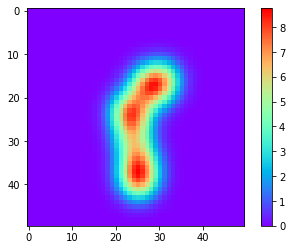

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


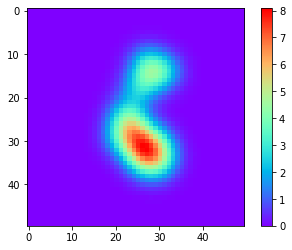

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


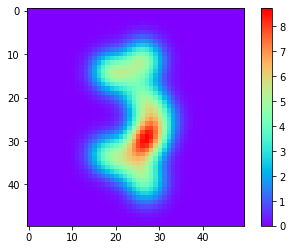

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


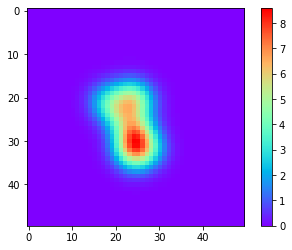

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


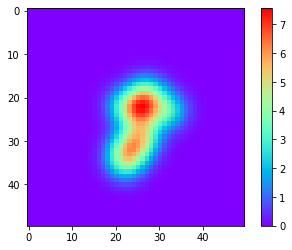

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


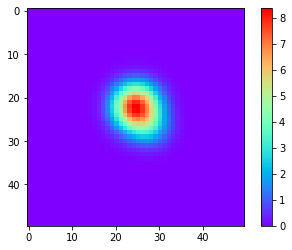

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


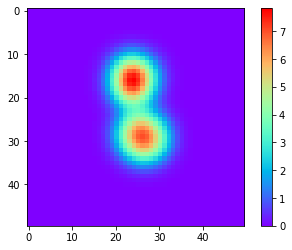

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


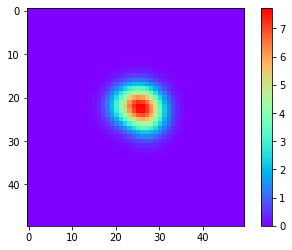

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


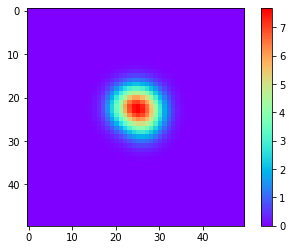

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


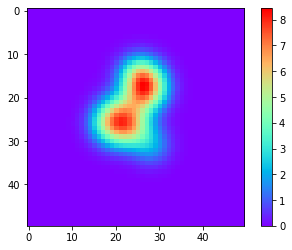

In [22]:
#visualize obtained results
print(args)
dataloader_iterator = iter(train_generator)
for i in range(10):
    volume, target = next(dataloader_iterator)
    with torch.no_grad():
        volume = volume.to(device)
        volume = model.blur(volume)
        print(volume.min(),volume.max())
#     print(volume.shape)
#     except StopIteration:
#         dataloader_iterator = iter(training_generator_waves)
#         volume, target = next(dataloader_iterator)
    volnp=volume[:,elements['C'],:,:,:].squeeze().cpu().numpy()
    volnp=volnp.sum(axis=2)
    molecule_visualization2D([volnp])
#     print(smile)
#     s = VolToDx()(**{'volume':volume[:,:,:,:,1].squeeze().numpy(),'origin':np.array([-17.5,-17.5,-17.5]),'dsteps':np.array([0.5,0.5,0.5])})

In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Net(dim=args["VOXEL_DIM"], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=args["TRANSF"],device=device,sigma_0 = args["SIGMA"],sigma_trainable = args["SIGMA_TRAIN"], mode = 'c')

{'EPOCHS_NUM': 100, 'PATIENCE': 25, 'SIGMA': 7, 'BATCH_SIZE': 128, 'TRANSF': 'w', 'NUM_EXP': '24', 'VOXEL_DIM': 50, 'LEARN_RATE': 1e-05, 'SIGMA_TRAIN': False}
tensor(0., device='cuda:0') tensor(1., device='cuda:0')


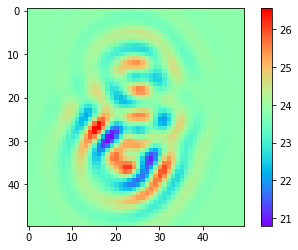

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


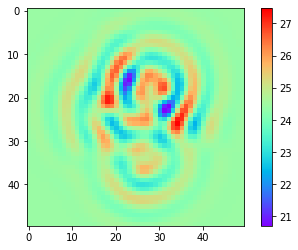

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


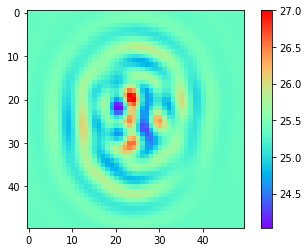

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


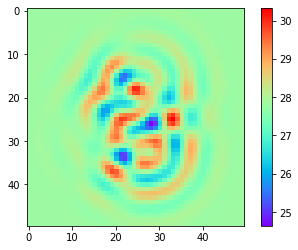

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


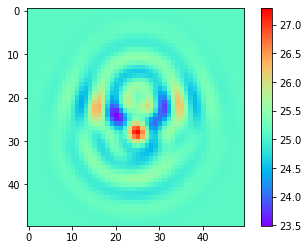

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


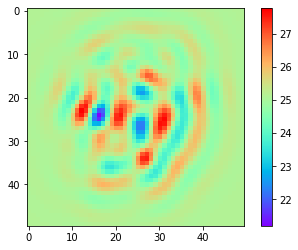

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


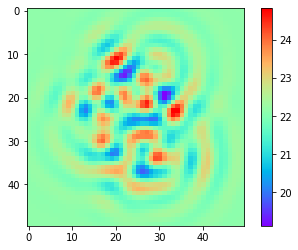

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


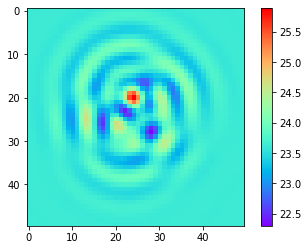

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


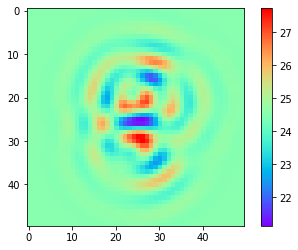

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


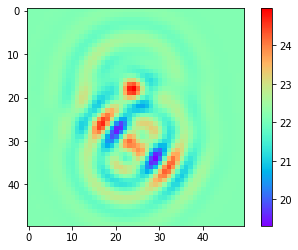

In [38]:
#visualize obtained results
print(args)
dataloader_iterator = iter(train_generator)
for i in range(10):
    volume, target = next(dataloader_iterator)
    with torch.no_grad():
        volume = volume.to(device)
        volume = model.blur(volume)
        print(volume.min(),volume.max())
#     print(volume.shape)
#     except StopIteration:
#         dataloader_iterator = iter(training_generator_waves)
#         volume, target = next(dataloader_iterator)
    volnp=volume[:,elements['C'],:,:,:].squeeze().cpu().numpy()
    volnp=volnp.sum(axis=2)
    molecule_visualization2D([volnp])
#     print(smile)
#     s = VolToDx()(**{'volume':volume[:,:,:,:,1].squeeze().numpy(),'origin':np.array([-17.5,-17.5,-17.5]),'dsteps':np.array([0.5,0.5,0.5])})

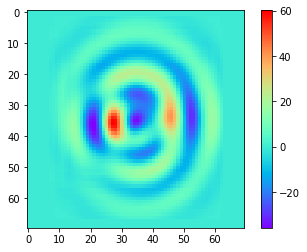

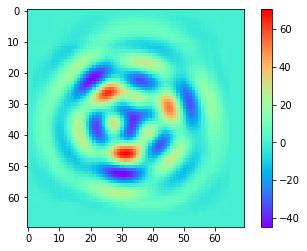

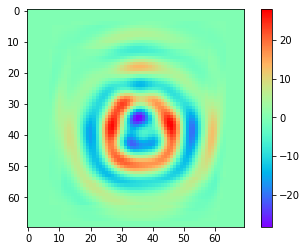

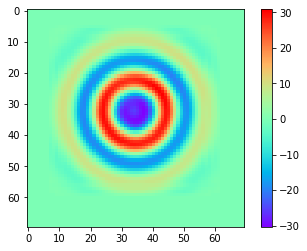

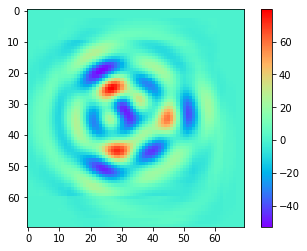

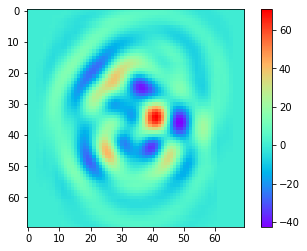

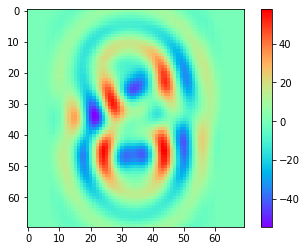

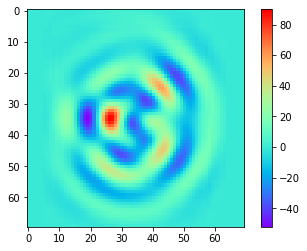

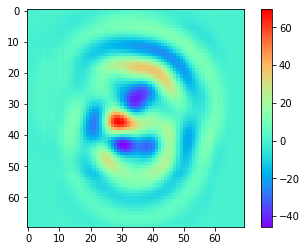

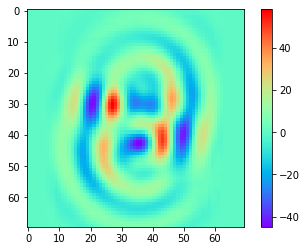

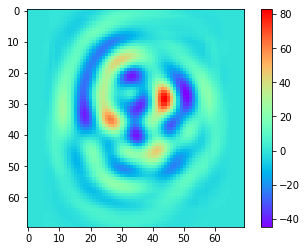

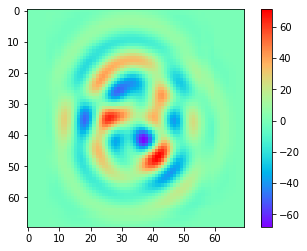

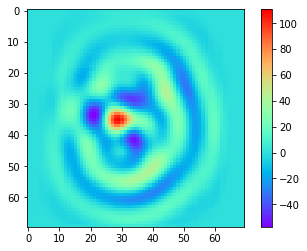

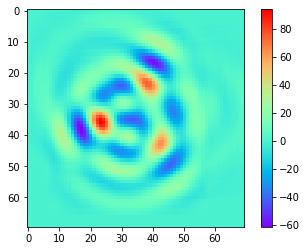

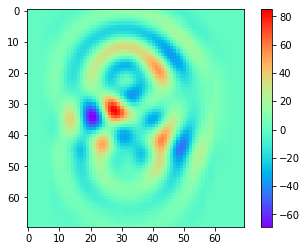

In [16]:
#visualize obtained results

dataloader_iterator = iter(training_generator_waves)
for i in range(15):
    volume, target = next(dataloader_iterator)
#     print(volume.shape)
#     except StopIteration:
#         dataloader_iterator = iter(training_generator_waves)
#         volume, target = next(dataloader_iterator)
    volnp=volume[:,elements['C'],:,:,:].squeeze().numpy()
    volnp=volnp.sum(axis=2)
    vis.molecule_visualization2D([volnp])
#     print(smile)
#     s = VolToDx()(**{'volume':volume[:,:,:,:,1].squeeze().numpy(),'origin':np.array([-17.5,-17.5,-17.5]),'dsteps':np.array([0.5,0.5,0.5])})

C[n+]1c2cc(N)ccc2cc2ccc(N)cc21


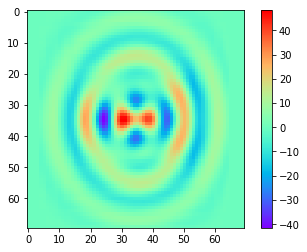

O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(Br)c([O-])c(Br)cc12


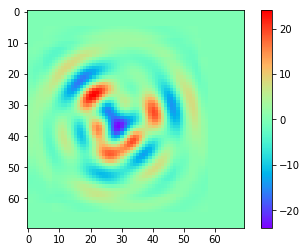

CCN(CC)C(=S)SSC(=S)N(CC)CC


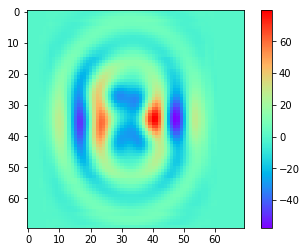

O=C(CCl)c1ccc(Cl)cc1Cl


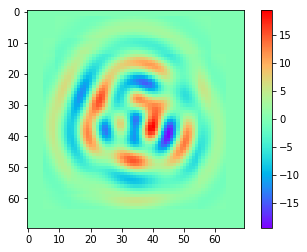

CN(C)c1ccc(C(=C2C=CC(=[N+](C)C)C=C2)c2ccccc2)cc1


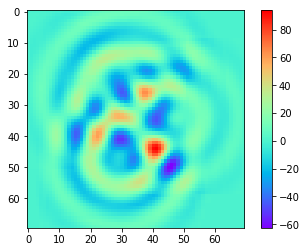

CCCCCCCCNC(C)C(O)c1ccc(SC(C)C)cc1


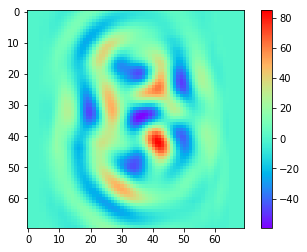

O[C@@H](CNC[C@H](O)[C@H]1CCc2cc(F)ccc2O1)[C@@H]1CCc2cc(F)ccc2O1


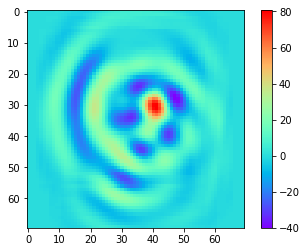

CC(C)(C)CC(C)(C)c1ccc(O)c(Cc2ccc(Cl)cc2Cl)c1


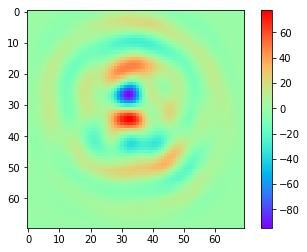

CCCCCNC(=N)N/N=C/c1c[nH]c2ccc(OC)cc12


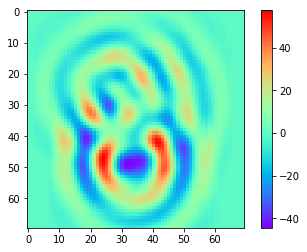

CCCCCCCCCCCCCC[N+](C)(C)C


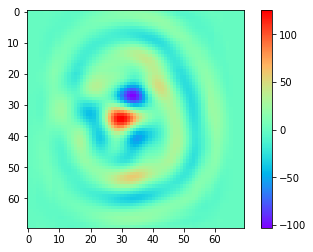

CCCCCCOc1ccc(C(=N)N(CCCC)CCCC)c2ccccc12


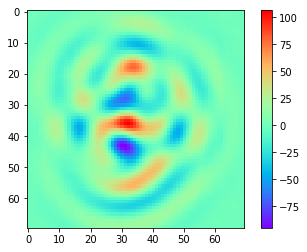

Clc1ccc(CO/N=C(\Cn2ccnc2)c2ccc(Cl)cc2Cl)c(Cl)c1


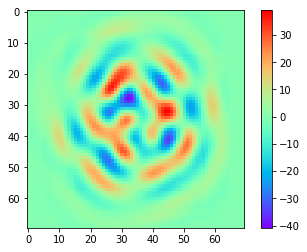

CCCCCCCCCCCCCCCC[n+]1ccccc1


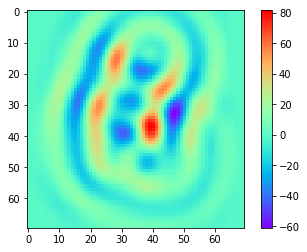

CN(C)c1ccc(C(=C2C=CC(=[N+](C)C)C=C2)c2ccc(N(C)C)cc2)cc1


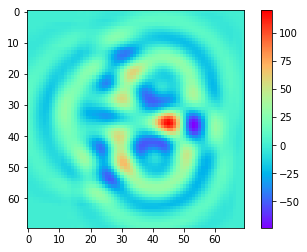

CCCCCCCCCCCC[N+](C)(C)CCOc1ccccc1


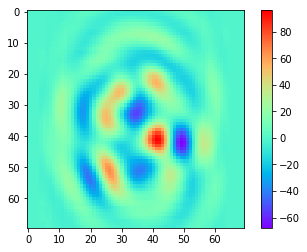

In [6]:
#visualize obtained results

dataloader_iterator = iter(training_generator_waves)
for i in range(15):
    volume, target = next(dataloader_iterator)
#     except StopIteration:
#         dataloader_iterator = iter(training_generator_waves)
#         volume, target = next(dataloader_iterator)
    volnp=volume[:,:,:,:,elements['H']].squeeze().numpy()
    volnp=volnp.sum(axis=2)
    vis.molecule_visualization2D([volnp])
#     print(smile)
#     s = VolToDx()(**{'volume':volume[:,:,:,:,1].squeeze().numpy(),'origin':np.array([-17.5,-17.5,-17.5]),'dsteps':np.array([0.5,0.5,0.5])})